Windkessel Python Module
========================



## Python module



After developing the windkessel models in [Windkessel Modelling](20201119183134-windkessel_modelling.md), I have implemented the windkessel solver as a python module. This module is available on github as part of the [PySeuille Package](https://github.com/TS-CUBED/PySeuille)<sup><a id="fnr.1" class="footref" href="#fn.1">1</a></sup>.

The python module `windkessel.py` contains:


# Footnotes

<sup><a id="fn.1" href="#fnr.1">1</a></sup> &#x2026; intended to be a package comprising all of the tools I use for physiological flow models


In [1]:
"""
Module for 2, 3, and 4 Element Windkessel Models

Calculates pressures before - p[y] - and after R1 - p[1]

usage:

import windkessel as wp

wk.solveWK(I, R1, R2, C, L, timeStart, timeEnd, N, method, initialCond, rtol)

where:

I:                      function object I(t) - volume flow

R1, R2, C, L:           windkessel parameters
                        set L = 0 for 3-Element WK

                        set R1 = 0 for 2-Element WK

Units:  either use physiological units (ml/s, mmHg/ml/s, ...)
        or SI units (m^3, Pa/m^3/s, ...), the result will be in
        consistent units (mmHg, or Pa)


Optional (use commas to give default option in case a subsequent option is
          to be given):

timeStart, timeEnd:     start and end time for integration
                        (float, default: 0, 10)

N:                      number of time steps for result
                        (integer, default: 10000)

method:                 integration method (string, default: "RK45")
                        see solve_ivp documentation for available methods

initialCond:            initial conditions (2 element list, default: [0, 0])

rtol:                   relative tolerance (float, default 1e-6)


Created on Sun Mar 21 22:04:43 2021

@author: acests3
"""
import numpy as np
import scipy as sp
import scipy.integrate

dt1 = 1e-6
dt2 = 1.1 * dt1


def ddt(I, t):
    return (I(t + dt1) - I(t - dt1)) / 2 / dt1


def d2dt2(I, t):
    return (
        (
            (I(t + dt1 + dt2) - I(t + dt1 - dt2)) / 2 / dt2
            - (I(t - dt1 + dt2) - I(t - dt1 - dt2)) / 2 / dt2
        )
        / 2
        / dt1
    )


def WK(t, p, I, R1, R2, C, L):
    dp = np.zeros(2)
    # The 4-Element WK
    # set L = 0 for 3EWK
    # set L = 0, R1 = 0 for 2EWK

    # Pressure at inlet:
    dp[0] = (
        R1 * ddt(I, t)
        + (1 + R1 / R2) * I(t) / C
        - p[0] / (R2 * C)
        + L / (R2 * C) * ddt(I, t)
        + L * d2dt2(I, t)
    )
    # Pressure after proximal resistance:
    # need to derive this with Ian
    # not valid for 4-element WK
    dp[1] = -p[0] / (R2 * C) + (1 + R1 / R2) * I(t) / C

    return dp


def solveWK(
    I,
    R1,
    R2,
    C,
    L,
    timeStart=0,
    timeEnd=10,
    N=10000,
    method="RK45",
    initialCond=[0, 0],
    rtol=1e-6,
):

    return sp.integrate.solve_ivp(
        lambda t, p: WK(t, p, I, R1, R2, C, L),
        (timeStart, timeEnd),
        initialCond,
        t_eval=np.linspace(timeStart, timeEnd, N),
        method=method,
        rtol=rtol,
        vectorized=True,
    )

To use this, put the module somewhere in your `PYTHONPATH` or in the same directory as the calling code and import it using:



In [1]:
import windkessel as wk

Then the windkessel solver can be called with:



In [1]:
pressure = wk.solveWK(I, R1, R2, C, L)

Where `I` is a function object describing the volume flow waveform at the inlet of the windkessel as a function of time `t`.

This inlet waveform can be given in arbitrary units, but the other parameters need to be consistent, and the output will be in a unit that relates to input and parameter units. Typical units for the inlet volume flow are:

-   pysiological: $[\mathrm{ml\ s^{-1}}]$
-   SI units: $[\mathrm{m^3\ s^{-1}}]$

Parameters are:

-   `R1`, `R2`: proximal and distal resistances in either $[\mathrm{mm_{Hg}\ ml^{-1}\ s}]$ or $[\mathrm{Pa\ s\ m^{-3}}]$.
-   `C`: compliance in either $[\mathrm{ml\ mm_{Hg}^{-1}}]$ or $[\mathrm{m^{3}\ Pa^{-1}}]$.
-   `L`: total arterial inertance in either $[\mathrm{mm_{Hg}\ s^{2}\ ml^{-1}}]$ or $[\mathrm{Pa\ s^{2}\ m^{-3}}]$.

The output of the windkessel model will be a 1-dimensional `ndarray` with two pressures (assuming the result of `wk.solve_WK` has been written into `pressure` as above):

-   `pressure.y[0]`: the pressure at the inlet of the windkessel
-   `pressure.y[1]`: the pressure after the proximal resistance for 3 and 4 element windkessel models

The pressure that is calculated by the windkessel will be in either $[\mathrm{mm_{Hg}}]$, or $[\mathrm{Pa}]$, depending on the units of input and the parameters.

*Note that parameters found in literature are mostly in the physiological system, while the CFD code `haemoFoam` will require parameters in SI units!*



### Derive p<sub>2</sub> for 4-Element WK model - the one in the module is 3EWK only!



## Using the module



### Installation and import of the module



Copy `windkessel.py` into your `PYTHONPATH` or into the working directory of your project. Then import the module as usual (I use the shorthand `wk`):



In [1]:
import windkessel as wk

We will also need `numpy` and `matplotlib.pyplot` (I use the usual shorthand namespaces for the import here) <sup><a id="fnr.1" class="footref" href="#fn.1">1</a></sup>:


# Footnotes

<sup><a id="fn.1" href="#fnr.1">1</a></sup> Never use the `import * from` method, this will cause functions to be overwritten and makes for code that is terrible to read and impossible to debug


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Seaborn makes the plots look a bit more modern
import seaborn as sns

sns.set_theme()
sns.set(rc={"figure.dpi": 300, "savefig.dpi": 300})
sns.set_style("white")

### Setting the input waveform



The input waveform needs to be defined as a function object that returns a value for the volume flow rate as a function of the parameter time



#### Generic sine based waveform with dicrotic notch



In this example I use a generic waveform that is based on a sine wave with a period time $T$, a systolic time $T_{syst}$, and a dicrotic notch time of $T_{dicr}$. The maximum and minumum flow rates are given as $I_{max}$ and $I_{min}$.

-   This waveform is similar to the flow into the aorta, if $I_{min}$ is set to zero and a dicrotic notch time is used
-   It can also be used as a generic waveform for an artery further down the tree with $T_{dicr} = 0$ and a set $I_{min}$.

$$
f(x)=\begin{cases}
(I_{max} - I_{min}) \sin(\pi \frac{t^{\%}}{T_{syst}} ) + I_{min} &,  (t^{\%}) \leq (T_{syst}+T_{dicr})\\
I_{min} &,  (t^{\%}) > (T_{syst}+T_{dicr})
\end{cases}
$$

where $t^{\%}$ is $t$ `modulo` $T$, i.e. the time in the current period, $0 \leq t^{\%} < 1$.

Setting the waveform parameters:



In [1]:
# Generic Input Waveform
# max volume flow in ml/s
max_i = 425

# min volume flow in m^3/s
min_i = 0.0

# Period time in s
T = 0.9

# Syst. Time in s
systTime = 2 / 5 * T

# Dicrotic notch time
dicrTime = 0.0

Define the waveform as a function.

*Note: I use a Boolean condition to implement the piecewise function!*



In [1]:
def I_generic(t):
    # implicit conditional using boolean multiplicator
    # sine waveform
    I = (
        (max_i - min_i) * np.sin(np.pi / systTime * (t % T))
        * (t % T < (systTime + dicrTime) )
        + min_i
    )

    return I

So let&rsquo;s have a look at the waveforms:

*Note: I am already calling the `ddt` and `d2dt` functions from the `windkessel` module. They are prefixed with their namespace `wk`.*

*Note 2: The `d2dt` function as it is implemented (central difference) is not defined at the beginning of the time range. So autoscale will not work and give you a flat line on a huge y-axis scale!*



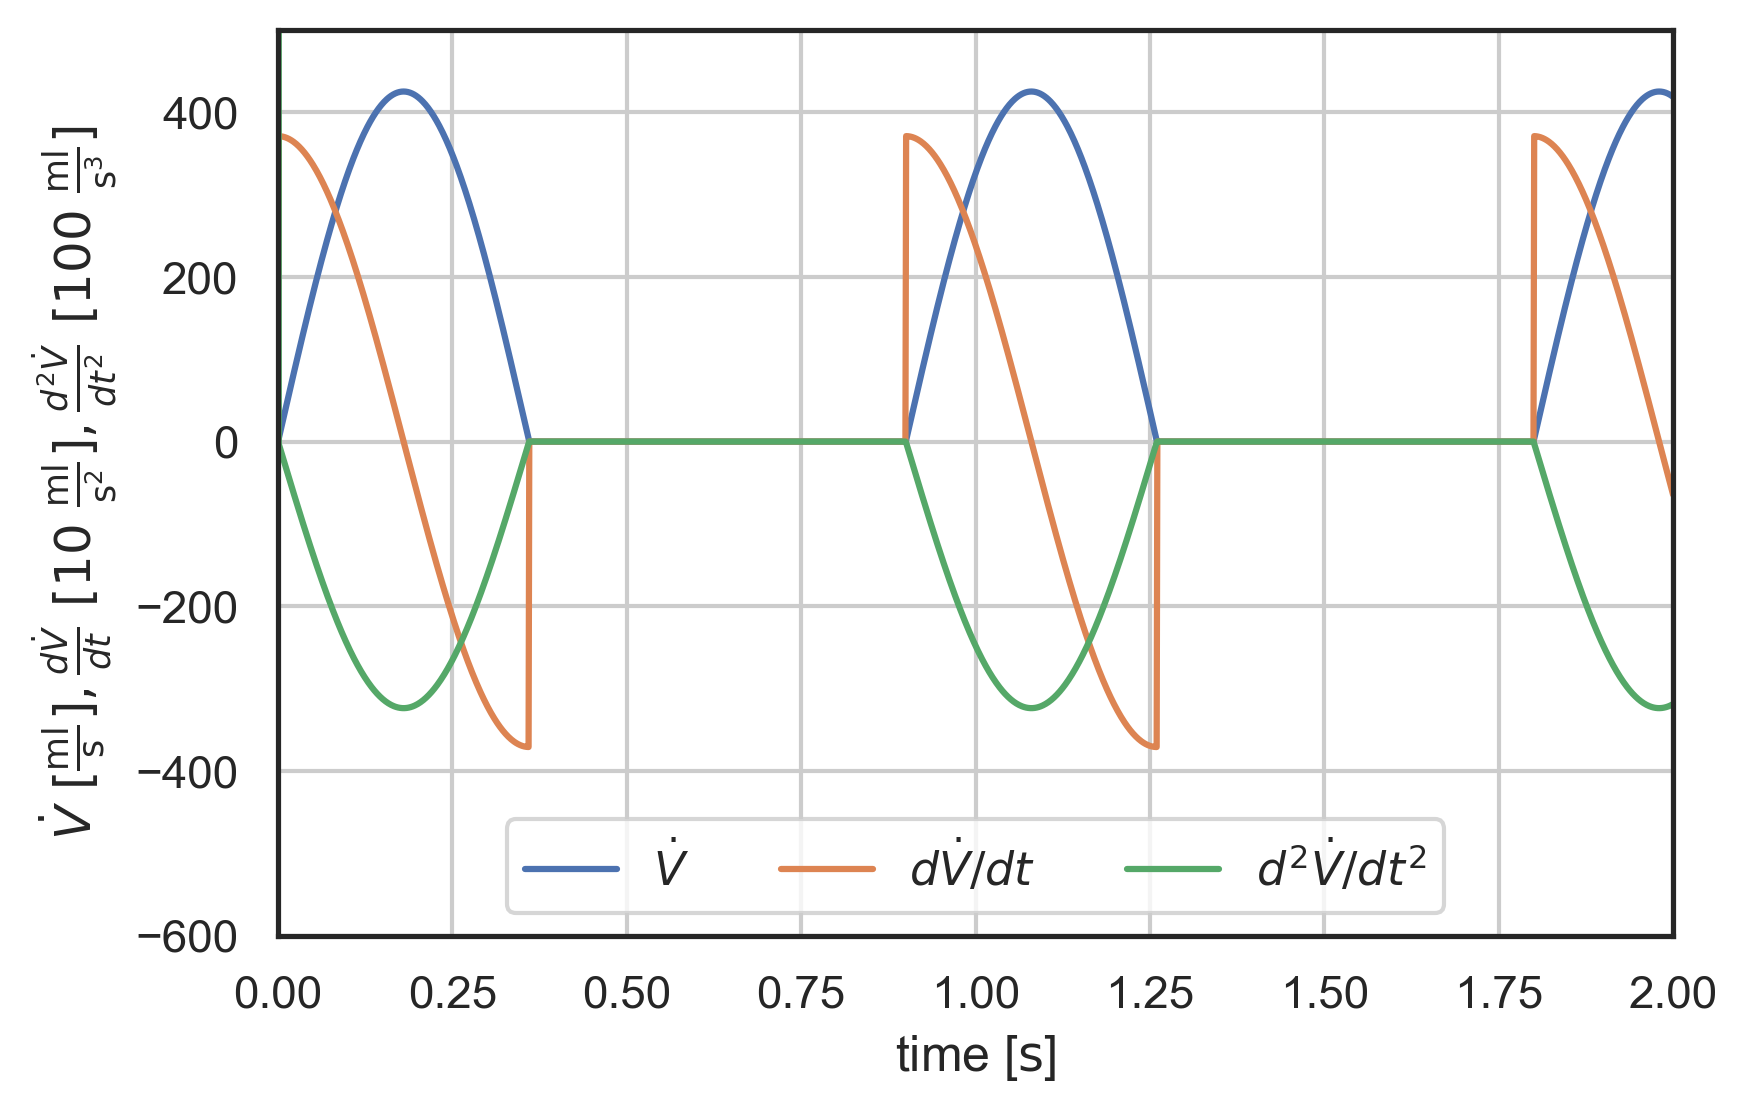

In [1]:
t = np.linspace(0, 2, 2000)

plt.plot(t, I_generic(t), label="$\dot{V}$")
plt.plot(t, 0.1 * wk.ddt(I_generic, t), label="$d\dot{V}/dt$")
plt.plot(t, 0.01 * wk.d2dt2(I_generic, t), label="$d^{2}\dot{V}/dt^{2}$")
plt.xlabel("time [$\\mathrm{s}$]")
plt.ylabel(
    "$\dot{V}\ [\mathrm{\\frac{ml}{s}}],\
    \\frac{d\dot{V}}{dt}\ [10\ \mathrm{\\frac{ml}{s^{2}}}],\
    \\frac{d^{2}\dot{V}}{dt^{2}}\ [100\  \mathrm{\\frac{ml}{s^{3}}}]$"
)
plt.xlim(0, 2)
plt.ylim(-600, 500)
plt.grid()
plt.legend(loc="lower center", ncol=3)

### Solving the windkessel equations



The solution of the windkessel equations is then done using a simple command `wk.solveWK`. The distinction between 2-element, 3-element, or 4-element windkessel models is done via selection of the model parameters `R1`, `R2`, `C`, and `L`. All parameters must be given, `R1` and `L` can be set to `0.0` to eliminate the element from the model.

*Note: `R2` and `C` must not be set to zero, which would result in a division by zero.*

*Note 2: If `C` is set to a very low value the windkessel model may not finish successfully.*



In [1]:
# Set parameters for 3-Element Windkessel Model
R1 = 0.01
R2 = 1
C = 2.0
L = 0.0

startTime = 0
endTime = 30
N = (endTime - startTime) * 1000

pressure = wk.solveWK(I_generic, R1, R2, C, L, startTime, endTime, N)

# Note: all other parameters to wk.solveWK are optional
#       if they are not given, defaults will be used
#       Here I use time range from 0 to 30 and 30000 steps
#       to override the default of 0, 10, 10000

And plot the result:



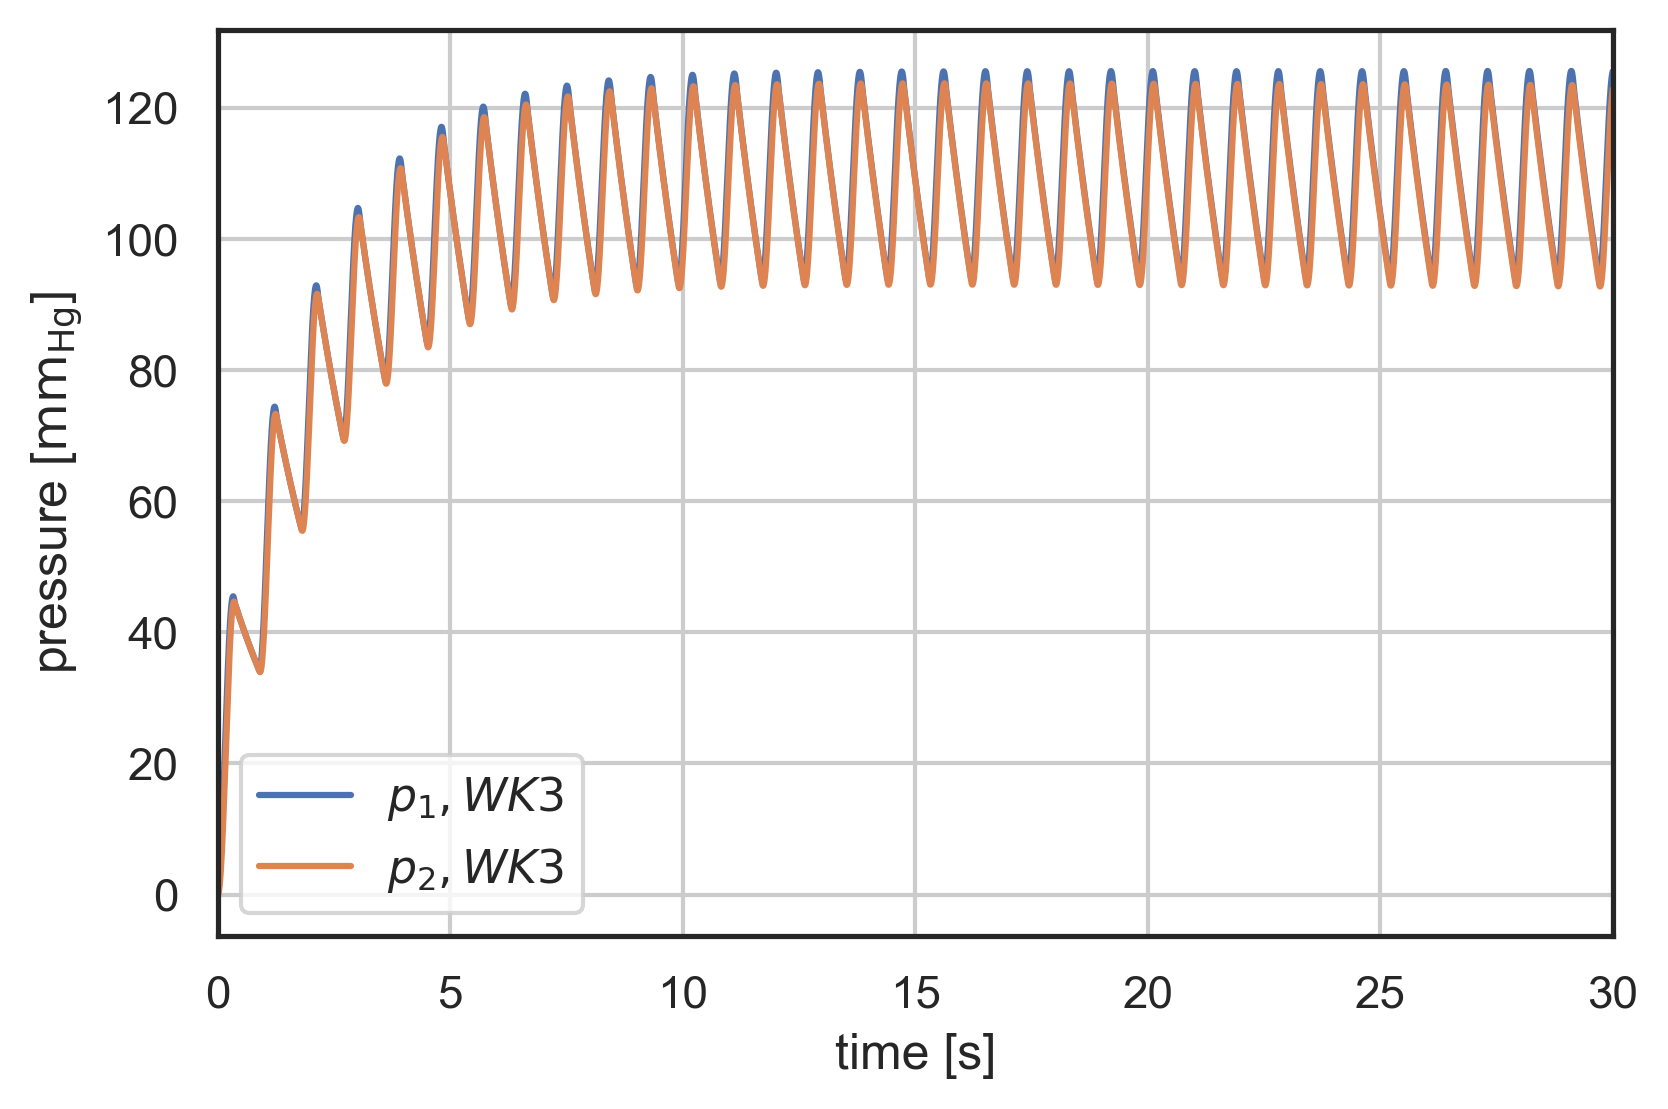

In [1]:
# the solution is returned as an array with labels 't' and 'y'
# where 'y' is a vector array with two entries
# y[0] - pressure before R1
# y[1] - pressure after R2

# plot curves
plt.xlabel("time [s]")
plt.ylabel("pressure [$\\mathrm{mm_{Hg}}$]")
plt.xlim(0, 30)

# plot first and second component (index 0, 1) of array 'y'
# over array 't':
plt.plot(pressure.t, pressure.y[0], label="$p_1, WK3$")
plt.plot(pressure.t, pressure.y[1], label="$p_2, WK3$")
plt.legend()
plt.grid()

Let&rsquo;s have a closer look at the last 10% of that plot:



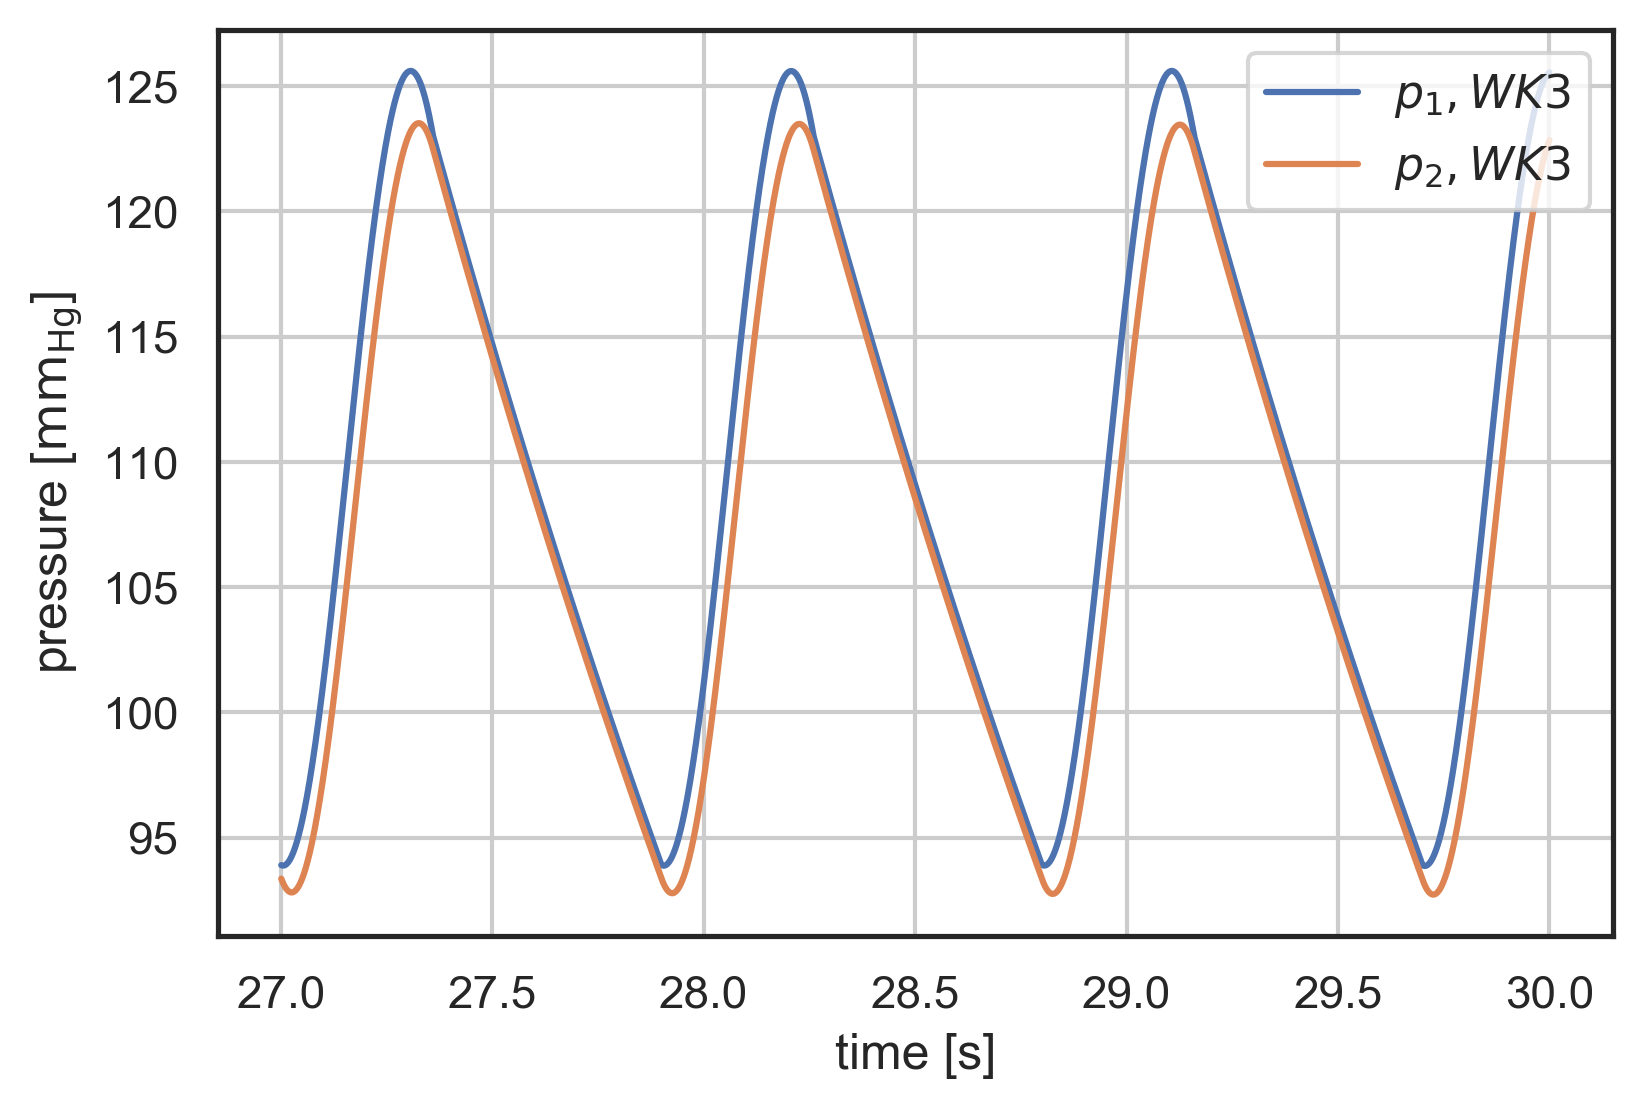

In [1]:
# plot curves
plt.xlabel("time [s]")
plt.ylabel("pressure [$\\mathrm{mm_{Hg}}$]")

startN = int(0.9 * N)
# plot first and second component (index 0, 1) of array 'y'
# over array 't':
plt.plot(pressure.t[startN:], pressure.y[0][startN:], label="$p_1, WK3$")
plt.plot(pressure.t[startN:], pressure.y[1][startN:], label="$p_2, WK3$")
plt.legend()
plt.grid()